# Basic K-Means Clustering

##### Note: must run [pip install whoosh], [pip install transformations]

In [4]:
from whoosh import index, writing, scoring
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import QueryParser
import os.path
from pathlib import Path
import tempfile
import subprocess
import csv
import codecs
import pandas as pd
import re
import os.path
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn import preprocessing
import transformations as trafo
import matplotlib.pyplot as plt
from collections import Counter
###comment

In [5]:
# SETTINGS
# Paths
DIRECTORY = ""
OUTPUT = os.path.join(DIRECTORY, "output.csv")

# Debugging - print entire array
np.set_printoptions(threshold=np.nan)

## Step 1:
### Lower case, remove punctuation, stemming, remove stop words

In [6]:
def createIndex(schema):
    # Generate a temporary directory for the index
    indexDir = tempfile.mkdtemp()

    # create and return the index
    return index.create_in(indexDir, schema)


def addFilesToIndex(indexObj, csvPath):
    # open writer
    writer = indexObj.writer()

    # open csv
    with codecs.open(csvPath, "r", "ISO-8859-1") as csvfile:
        # create csv reader object
        csvreader = csv.DictReader(csvfile)
        # create dictionary to hold document values
        doc = {}
        # instantiate index count
        i = 0
        
        # read each row in file
        for row in csvreader:
            value = row["Negative Feedback"]
            if value != "" and isinstance(value, str):
                doc[i] = value
                writer.update_document(index = str(i), cell_content = value)
            i += 1
        writer.commit()

In [7]:
# create text analyzer
cleaningFilter = RegexTokenizer() | LowercaseFilter() | IntraWordFilter() | StopFilter() | StemFilter()

# define a Schema with the new analyzer
schema = Schema(index = ID(stored=True),
                   cell_content = TEXT(analyzer = cleaningFilter, stored = True))

# create the index based on the new schema
index2 = createIndex(schema)

# index cell contents in refined.csv to index2
# TODO: put index2 into dataframe
addFilesToIndex(index2, OUTPUT)

# define a reader object on the index
myReader = index2.reader()

#### Inspect Index

In [9]:
# Is it empty?
print("Index is empty?", index2.is_empty())

# How many cells indexed?
print("Number of indexed files:", index2.doc_count())

# First 25 documents
#[(docnum, doc_dict) for (docnum, doc_dict) in myReader.iter_docs()][0:25]

# list indexed terms for field "cell_content"
all_words = [term for term in myReader.field_terms("cell_content")]

# Term frequency for a given term
print(myReader.frequency("cell_content", "android"))

# 1000 most distinctive terms according by TF-IDF score
mostDistinctiveWords = [term.decode("ISO-8859-1") for (score, term) in myReader.most_distinctive_terms("cell_content", 1000)]
# mostDistinctiveWords

# 1000 most frequent words
mostFrequentWords = [term.decode("ISO-8859-1") for (frequency, term) in myReader.most_frequent_terms("cell_content", 1000)]
# mostFrequentWords

Index is empty? False
Number of indexed files: 1110
47.0


In [10]:
# Create a binary encoding of dataset based on the selected features (X)
# go through each document --> tokenize that single document --> compare with total word list
# TODO: change to frequency encoding
tokenizer = RegexpTokenizer(r'\w+')
df_rows = []

word_list = mostFrequentWords

with codecs.open(OUTPUT, "r", "ISO-8859-1") as csvfile:
    csvreader = csv.DictReader(csvfile)
    for i, row in enumerate(csvreader):
        value = row["Negative Feedback"]
        if value != "" and isinstance(value, str):
            file_words = tokenizer.tokenize(value)
            df_rows.append([1 if word in file_words else 0 for word in word_list]) 
    X = pd.DataFrame(df_rows, columns = word_list)

In [11]:
# convert to numpy array
data = np.array(df_rows)

X_normalized = preprocessing.normalize(data, norm='l2')

## Step 2

### K-means Clustering (Scikit-learn)
##### Note: must run pip install scikit-learn, pip install scipy

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.cluster import hierarchy
import random

In [24]:
# Singular Test Instance
num_clusters = 19

# Number of clusters
kmeans = KMeans(n_clusters=num_clusters)
# Fitting the input data
kmeans = kmeans.fit(X_normalized)
# Getting the cluster labels
labels = kmeans.predict(X_normalized)
# Centroid values
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# print(centroids)
print(labels)

[12  4 10  2 14  9 13  6  4 18 12 12  0 12  3 11 12 14 11  4  2 14  4  1
 14  0 12 12 14 11 12  7  2 10 15 14 10 13 14 14  9  2 14  3 12 15 12  2
 12 10 14  0  6 14 10 12  4  4 10  0 14 14  3 16 11  3  3  3 12 12 11 12
 11 11  6 10  0  5  2 16 14  4  3 14  9  9 10  0  5  0 18  6  6  4  6  4
 10 12  6 14 10 14  2 14  0 14 10  8  7  0 12 12 11 11 14 18 13  3 10 10
 14 13  1 14 18 11 12 10  4  5 14  2  2  7  9  2 14  7  1 14 14  4 14 12
 13  6  0 10  2  0 12 14  2  1  2 17  7 14  2  0 18 12 10  3 14  0  4 12
  5 10  4 11  1  1  4 14 14 14  4  5 11  2 14  1 14 12  6 14 14 13  0 14
 11 13 10  3 14 10  6  6 12 14 12 11 14 14 10 14  6  0 14  2  9 14  0  0
  2  3 14 14 11 16  3  4  0 15 14 13 12  1  0 10  3 13 13  6 14 14  1 13
  2  5 10  2 12 13  4 13 13 12 12 11  0  9 10  9  4 14 14  1 11 14 16 16
 14 14 14  4 14 11  0 18 12  3  3 14  5 10  4 10 14  6 14  4 12 12 11 10
  4 12  0  0  0 16 11  1 10  0 12 14  4 14  4  1 14 12  0  9  6 10 14  9
  4  6 12  0 16 14 13 12 12 14 10 12 14  1  6 14 12

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

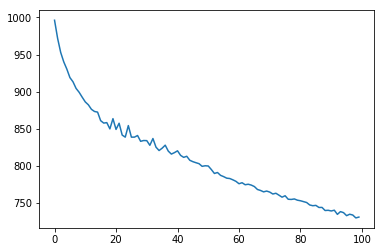

In [20]:
# Find best k for clusters (elbow method)
k_average_inertia = []
local_inertia = []
random_states = []
num_tests = 5

for i in range(num_tests):
    state = random.randint(1,1000)
    random_states.append(state)

for i in range(100):
    for state in random_states:
        # Number of clusters
        kmeans = KMeans(n_clusters=i+1, random_state = state)
        # Fitting the input data
        kmeans = kmeans.fit(X_normalized)
        # Calculate inertia (within-cluster sum-of-squares)
        local_inertia.append(kmeans.inertia_)
    k_average_inertia.append(sum(local_inertia)/len(local_inertia))
    local_inertia = []
    print(i+1, end=" ")


plt.plot(k_average_inertia)

In [23]:
hardcoded_k_average_inertia = [996.120161061241,
 971.7098230964491,
 952.7861704492907,
 940.0619752427674,
 930.3657061792022,
 918.9592073457455,
 913.3144481223687,
 904.4124416003946,
 899.1722839754657,
 892.5348899721223,
 886.2081548665992,
 882.3200576031841,
 876.2561460493231,
 873.3579443954989,
 872.4941626903143,
 860.9788965520158,
 857.7256214194788,
 858.3513261388655,
 849.9107789756945,
 863.6939208114576,
 849.2037298957055,
 857.5146014551663,
 841.618518098966,
 838.8230763546278,
 854.3754492848997,
 838.8054622193555,
 838.8318530622613,
 841.0033798673194,
 833.2005084255725,
 834.2733973798707,
 834.1165654175222,
 827.8246892480283,
 836.952528229488,
 825.3197614813049,
 820.8049740765731,
 823.9590905268827,
 828.0031583721487,
 819.973746683602,
 816.0232287008629,
 817.9730221219867,
 820.4044853040772,
 814.288086508465,
 811.6128144203527,
 813.0555432612409,
 807.676283599881,
 805.7903274017217,
 804.3946283001492,
 803.1046028442654,
 799.5363026790563,
 800.2921945062519,
 799.9831930769775,
 795.2297044615738,
 789.9335978665301,
 791.234355887476,
 787.3977369202623,
 785.6841859244969,
 783.6128876653244,
 783.1338156363867,
 781.3833871560394,
 779.36039738337,
 776.1094714925133,
 777.4673197143093,
 774.7611853114802,
 775.4384916877741,
 774.2833951321915,
 772.3287205585614,
 768.3819564072758,
 767.067666157384,
 765.1877408787177,
 766.2524704529731,
 764.8723960514769,
 762.2987814004226,
 763.2951371245215,
 760.7149203386532,
 758.0283566804861,
 759.9373693631244,
 755.2356418617525,
 754.9851550722124,
 755.6487467539771,
 753.9849972170422,
 753.2065379394986,
 752.0247411403313,
 750.8518415434044,
 747.5611285933307,
 746.5314162043006,
 746.9835885662785,
 744.1933443536657,
 744.2392574129924,
 740.090415931636,
 740.3859578173405,
 739.4696035101149,
 740.4889528631908,
 734.9103664672026,
 738.5949419195221,
 737.2100816822667,
 733.1439525352407,
 735.0596370040473,
 734.0226564464822,
 730.1183747156763,
 731.249786453746]

array([ 92,  52,  58,  66,  64,  28,  62,  39,  12,  29,  78,  94, 123,
        34, 196,  16,  20,  10,  37])

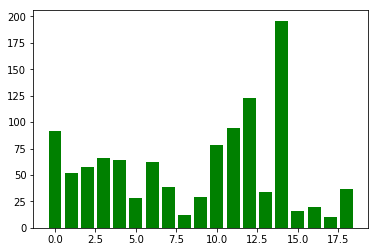

In [26]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
clusterCount = dict(zip(unique, counts))
plt.bar(clusterCount.keys(), clusterCount.values(), color='g')
counts

In [27]:
# See top 5 vectors closest to cluster centroid j

for j in range(num_clusters):
    d = kmeans.transform(X_normalized)[:, j]
    ind = np.argsort(d)[::-1][:5]
    print("Cluster", j)
    print("Indices of top 5 documents:", ind)
    print(np.array([doc_dict for doc_dict in myReader.iter_docs()])[ind]) 


# j = 2

# # the distance to the j'th centroid for each point in an array X 
# d = kmeans.transform(X_normalized)[:, j]
# ind = np.argsort(d)[::-1][:5]
# print("Cluster", j)
# print("Indices of top 5 documents:", ind)
# print(np.array([doc_dict for doc_dict in myReader.iter_docs()])[ind])
# X_normalized[ind]

Cluster 0
Indices of top 5 documents: [ 664  188 1109   50   99]
[[664
  {'cell_content': 'Permanentemente quiere instalar una "Actualizacion" que NO se si corresponde que se llama ff_adr0.0.2.zip', 'index': '1291'}]
 [188
  {'cell_content': 'hai boschetarule , lasa cenzura penala si lasa internetul liber sa mearga ,analfabetule LUATEAR DRACU BELITULE ,PROSTANAC CENZURATOR PENAL', 'index': '360'}]
 [1109
  {'cell_content': 'The layout is not very intuitive.', 'index': '2225'}]
 [50
  {'cell_content': "Permanent ad that I can't remove!!", 'index': '105'}]
 [99 {'cell_content': 'Video playback is laggy', 'index': '200'}]]
Cluster 1
Indices of top 5 documents: [1043  443  188  664 1109]
[[1043
  {'cell_content': 'Firefox for Android has a setting to set your homepage (Settings / General / Home / Set a Homepage).  Nice bit of useless UI, that. It does NOTHING.', 'index': '2075'}]
 [443
  {'cell_content': 'crash n lag..slowdown pc..memory hungry', 'index': '851'}]
 [188
  {'cell_content': '

Cluster 15
Indices of top 5 documents: [1109 1062  506  835  477]
[[1109
  {'cell_content': 'The layout is not very intuitive.', 'index': '2225'}]
 [1062
  {'cell_content': 'Ever since the last update Firefox is ungodly slow and crashes.  No other changes to computer and no malware.', 'index': '2098'}]
 [506 {'cell_content': 'Slow working slow interface', 'index': '966'}]
 [835
  {'cell_content': 'Some of the pictures cover the text.', 'index': '1649'}]
 [477
  {'cell_content': "Right now.ypur interfering with my job.i can't comment further", 'index': '905'}]]
Cluster 16
Indices of top 5 documents: [1109  304  266  275  278]
[[1109
  {'cell_content': 'The layout is not very intuitive.', 'index': '2225'}]
 [304
  {'cell_content': "Why would ask such a question, I'm busy. ", 'index': '558'}]
 [266
  {'cell_content': "What a piece of goddam motherfucking shit this goddam browser is! It can't even remember history of the last few fucking pages ASSHOLES!", 'index': '495'}]
 [275 {'cell_cont

In [ ]:
# Spectral Clustering

# from sklearn.cluster import SpectralClustering
# from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
# similarity_matrix = 1 - pairwise_distances(df_rows, metric='cosine')
# cosineScores = pd.DataFrame(similarity_matrix)
# clusters = SpectralClustering(n_clusters = 5, affinity = 'precomputed').fit(cosineScores)

## Step 3 Cluster Visualization

In [ ]:
# %matplotlib inline

# import seaborn as sns; sns.set()
# import pprint

In [ ]:
# def fit_and_plot(algorithm,title):
#     col = ['bo','ro','co', 'mo','ko']
#     algorithm.fit(X)
#     n_clusters = algorithm.n_clusters
#     lab = algorithm.labels_
#     reds = lab == 0
#     blues = lab == 1
#     for jj in range(n_clusters):
#         plt.plot(X[lab == jj, 0], X[lab == jj, 1], col[jj])
#     plt.xlabel("$x_1$")
#     plt.ylabel("$x_2$")
#     plt.title(title)
#     plt.axes().set_aspect('equal')   

In [ ]:
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(clusters.get_params())
# fit_and_plot(clusters,"Spectral clustering on two circles")

In [ ]:
# y_kmeans = kmeans.predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## Step 4 Label Clusters with Key Words

### TF-IDF Frequency Normalization

In [ ]:
# pull out documents of each cluster --> tf idf for key words

test_cluster = 12

# indices for cluster 0
indices = [index for index, clusterNum in enumerate(labels) if clusterNum == test_cluster]

# documents in cluster 0
clusterCorpus = [doc_dict['cell_content'] for (docnum, doc_dict) in myReader.iter_docs() if docnum in indices]
print(clusterCorpus)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
# X_tf = vectorizer.fit_transform(clusterCorpus)

response = vectorizer.transform(clusterCorpus)
feature_names = vectorizer.get_feature_names()

In [ ]:
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

# TODO

n = 10
top_n = feature_array[tfidf_sorting][:n]

feature_array[tfidf_sorting]

# print(top_n)